<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-simplest-ageometeorological-crop-model" data-toc-modified-id="The-simplest-ageometeorological-crop-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The simplest ageometeorological crop model</a></span><ul class="toc-item"><li><span><a href="#Main-crop-modelling:-production-efficiency-model-(PEM)" data-toc-modified-id="Main-crop-modelling:-production-efficiency-model-(PEM)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Main crop modelling: production efficiency model (PEM)</a></span></li><li><span><a href="#Crop-limitations" data-toc-modified-id="Crop-limitations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Crop limitations</a></span><ul class="toc-item"><li><span><a href="#Temperature-control" data-toc-modified-id="Temperature-control-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Temperature control</a></span></li><li><span><a href="#Water-availability" data-toc-modified-id="Water-availability-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Water availability</a></span></li></ul></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li><li><span><a href="#Putting-it-together:-Your-first-crop-model!" data-toc-modified-id="Putting-it-together:-Your-first-crop-model!-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Putting it together: Your first crop model!</a></span><ul class="toc-item"><li><span><a href="#Inputs" data-toc-modified-id="Inputs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Inputs</a></span></li><li><span><a href="#Limitations-to-GPP" data-toc-modified-id="Limitations-to-GPP-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Limitations to GPP</a></span></li><li><span><a href="#Exploring-the-model" data-toc-modified-id="Exploring-the-model-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Exploring the model</a></span></li></ul></li><li><span><a href="#Concluding-remarks" data-toc-modified-id="Concluding-remarks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Concluding remarks</a></span></li></ul></div>

<div style="float:right">
<table>
<tr>
    <td> <img src="figs/nceo_logo.png" alt="Drawing" style="width:200px;height:40px;"/> </td>
    <td> <img src="figs/gssti_logo.png" alt="Drawing" style="width:200px;height:40px;"/> </td>
    <td> <img src="figs/multiply_logo.png" alt="Drawing" style="width:40px;height:40px;"/> </td>
</tr>
    </table>
</div>

# Towards a crop model: production efficiency model

**Author:** Jose Gómez-Dans (NCEO & UCL)  `j.gomez-dans@ucl.ac.uk`

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import gdal
import pandas as pd
%matplotlib inline

from modis_funcs import *
from meteo_funcs import *

# Don't nag!
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/ucfajlg/.local/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## The simplest ageometeorological crop model

### Main crop modelling: production efficiency model (PEM)

We can think of the crop turning incoming radiation into carbon, which then gets allocated to different organs (including leave, grain, roots, etc.). The simple PEM model introduced by Monteith is basically that gross primary productivity (GPP) can be written as

$$
GPP(t) = fAPAR\cdot PAR_{inc} \cdot \epsilon,
$$

where $fAPAR$ is the fraction of active photosynthetic radiation absorbed by the canopy (hence related to the amount and colour of leaves), $PAR_{inc}$ is the incoming radiation in the PAR region ($400-700 \textrm{nm}$), and $\epsilon$ is an energy conversion factor (e.g. how many grams of C per square meter do we produce for a given amount of absorbed radiation).

This model is incredibly simple: we do not account for any stressors, pests, management, soils, ... But simplicity has its own advantages!

### Crop limitations

In warm climates, we have two important limitations to crop develoment: water availability and heat. We can think of environmental stressors as limiting photosynthetic activity, so having no effect when the crop is not stressed and gradually decreasing photosynthesis. Let's see how this can be accomplished.



<div>
    <img src="https://p7.hiclipart.com/preview/562/575/818/warning-sign-clip-art-attention-thumbnail.jpg" style="float:left;width:80px;" /><p>Note that this notebook uses a set of constants for parameters. These are all made up and have been selected without looking at the (ample) bibliography on this topic. If you are thinking of re-using this, please be aware of this fact!</p>                                                                                                                                                                                                                                                 
</div>


#### Temperature control

Photosynthesis is controlled by temperature, with typically a "cold" cutoff point, an optimal temperature, and a point where too much heat hampers photosynthetic activity:

$$
f(T)=\begin{cases}
0\; T<T_{thresh,min}\\
\frac{T-T_{thresh,min}}{T_{thresh,opt} - T_{thresh,min}}\; T_{thresh,min} \le T \le T_{thresh,opt}\\
\frac{T_{thresh,max} - T}{T_{thresh,max} - T_{thresh,opt}}\;  T \ge T_{thresh,opt}\\
\end{cases}
$$


Text(0, 0.5, 'C assim rate [-]')

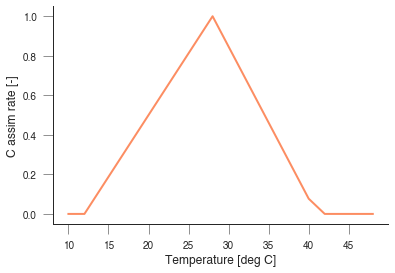

In [2]:
def temp_constraint(temp, t_min=12, t_max=41, t_opt=28):
    f_temp = np.zeros_like(temp)
    f_temp[temp < t_min] = 0.
    f_temp = np.where(np.logical_and(t_min <= temp, temp <= t_opt),
             (temp - t_min)/(t_opt - t_min),
             f_temp)
    f_temp = np.where(temp >= t_opt,
             (t_max - temp)/(t_max-t_opt),
             f_temp)
    f_temp[f_temp<0] = 0.
    return f_temp
temp_axs = np.arange(10, 50, 2)
plt.plot(temp_axs, temp_constraint(temp_axs))
plt.xlabel("Temperature [deg C]")
plt.ylabel("C assim rate [-]")

#### Water availability
If we consider that vegetation growth is only limited by water availability, a simple model would basically look at water balance: precipitation minus evapotranspiration. If this balance is positive (more rain than ET), we may initially conclude that in principle, crops will not be stressed by drought. One of the simplest ways to calculate ET is to use a version of Hargreaves equation:

$$
ET_{0} = \frac{0.0023}{\lambda}\cdot \left[T_{max} - T_{min} \right]^{0.5}\cdot R_{surf}\left[T_{mean} - 17.8\right]
$$
where the daily reference evapotranspiration $ET_0$ is given in $[mm\cdot d^{1}]$, $T_{max,min,mean}$ are respectively the daily max, min and mean temperatures in degrees C, $R_{surf}$ is the surface radiance in $kJm^{-2}d^{-1}$ and $\lambda$ is the latent heat of vaporisation. We only chose this equation for its simplicity. More accurate and better methods are the FAO56/Penman-Monteith approach although it depends on wind speed, an unreliable quantity in our reanalysis dataset.

A very simple but also effective model for the effect of drought (not considering soil moisture!) is to just define a linear scaling point that relates the precipitation/ET ratio (e.g. available water vs water requirements for unstressed photosynthesis):

$$
f(P)=\begin{cases}
\frac{P}{ET_{0}}\, \textrm{if } 0\le P \le ET_{0}\\
1,\, P>ET_{0}\\
\end{cases}
$$


In [3]:
def water_limitation(precip, et):
    return np.where(precip >= et, 1, precip/et)


### Discussion

The code below allows you to plot the stressor functions for different years and different regions. Try to explain the patterns you get. To simplify visualisation, the plots also show a running mean of the stressors.

* What are some interesting patterns you can spot?
* Any obvious correlations?
* What about the shape of the stress time signals, do these look sensible to you?
* What might be any clear shortcomings that we are ignoring here?
* The smoothed lines are intriguing. Do they look more sensible to you or not?
* The smoothed lines can be seen as an approximation of "memory" in the system. This is a vague term, can you think of some process that would keep memory that we're ignoring here?

In [4]:
plot_stressors();

interactive(children=(Dropdown(description='Region:', index=6, options=('Ashanti', 'Brong_Ahafo', 'Central', '…

## Putting it together: Your first crop model!

### Inputs

The previous discussion deals with stressors. Assuming we know the conversion efficiency, and that we have properly calibrated the stress functions, we now need to turn our attention to the energy going into the system, the intercepted PAR:

$$
I_{par} = fAPAR \cdot PAR_{inc}
$$

We can then use a multiplicative constant ($\epsilon$) that converts from $I_{par}$ to carbon. $\epsilon$ is thus some maximum efficiency conversion rate, with units of e.g. $gC\cdot m^{-2} d^{-1} kJ^{-1}$. It basically encodes the potential C gained by the system. 


### Limitations to GPP

We now consider the limiting factors considered above, $f(T)$ and $f(W)$. The daily GPP can be written as

$$
GPP(t) = fAPAR\cdot PAR_{inc} \cdot \epsilon \cdot f(T, t)\cdot f(W,t),
$$

Now, GPP is one part of the problem. In this discussion, we are ignoring the critical part of losses in respiration (C lost by the system), such as dark respiration and autotrophic respiration. We are also ignoring the fact that $\epsilon$ probably has a number of other controls (e.g. the efficiency changes with crop development stage, and the relationship with $I_{par}$ may not be linear across all $PAR_{inc}$).

We could extend the model to calculate NPP, and could then decide how that extra C is *allocated* to different tissues (e.g. stem, roots, reproductive organs, leaves, ...). Allocation is a complicated process, and maybe a quick hacky way of getting around it is to assume that after flowering, most of the C is allocated to the seed. This assumption is pretty effective in crops, which have already been bred to maximise grain production, but again, requires testing.

### Exploring the model
We have now defined our model. Let's get some actual data! Since large areas averages blur the picture, let us look at a pixel in Garu Tempane. Here's how Google Maps shows the area:


In [5]:
%%html

<iframe src="https://www.google.com/maps/embed?pb=!1m18!1m12!1m3!1d5261.554479365376!2d-0.23048958417343066!3d10.69650526133724!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x0%3A0x0!2zMTDCsDQxJzQ3LjQiTiAwwrAxMyczNC4wIlc!5e1!3m2!1sen!2suk!4v1573820145931!5m2!1sen!2suk" width="600" height="450" frameborder="0" style="border:0;" allowfullscreen=""></iframe>

We have extracted the LAI and fAPAR for this pixel for the entire time series, as well as the relevant climate information. The following widget plots both the LAI/fAPAR, as well as the abiotic stress factors for different years. Have a look at it, and try to figure out what's going on here!

In [6]:
plot_lai_stress();

interactive(children=(IntSlider(value=2010, description='year', max=2018, min=2010), Dropdown(description='pro…

Some years (2014 and 2015) show what appears a big drop in the LAI/fAPAR signal. This could be related to scrubs growing, and then afterwards, the main crop establishing itself (the crop calendar for Garu suggests the second "bump" is crop). We also see that the time series is quite noisy. This is expected: retrieving LAI from EO data is fraught with complications, and we expect the inference of LAI to be uncertain. 

We now have all the ingredients to calculate GPP. The following bit of code does just that, it implements our crop model above (with all the important caveats!) and allows you to integrate GPP over time. Change the bounds of the integration and the year, and see how crop development changes.

In [7]:
crop_model();

interactive(children=(IntSlider(value=2015, description='year', max=2018, min=2010), SelectionRangeSlider(desc…

Generally speaking, we see a typical sigmoid function, with a fast develoment at first, followed by a "plateau", as in typical expolinear growth models often used for crops (see e.g. [Yin et al (2002)](https://pdfs.semanticscholar.org/999c/da5119bcb979e183d170cb0e7345031125e0.pdf)).

## Concluding remarks

We have developed a very simplified production efficiency model (PEM) for crops based on both remote sensing information (fAPAR) and meteorological information. The model assumes we can use a linear product to go from incident PAR radiation to the energy absorbed by the canopy just by using fAPAR as a modulating factor. We then convert this incoming energy into C by using an efficiency conversion factor, and we finally add temperature and water stressors.

There are limitations. By focusing in Northern Ghana, we have a mostly complete fAPAR time series, but in coastal areas with persisten cloud, the observational opportunity would be much lower, greatly hampering our approach.

We have assumed no allocation, ignored respiration losses, and not taken into account uncertainties in e.g. fAPAR or meteorological inputs. This however is a simple and intuitive view of how vegetation develops. A lot of the important factors that limit growth have been left out. Adding these factors can add significant complexity to the model, which is why we will now look at mechanistic crop growth models, that are able to predict crop growth using meteo, soil and crop variety/type parameters. We will see that these models can go very wrong.

The other important thing is that EO-derived parameters are uncertain, have gaps and are incomplete. They give us the only link to the "real world", so using them to enhance our modelling is absolutely crucial. Data assimilation is what allows you to blend these two things to gain clearer insights in what's really going on in the ground.